In [1]:
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score as acc
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import svm
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf

In [2]:
def predict(X_train, y_train, X_test, y_test):
    y_train_pred = clf.predict(X_train)
    print("Training accuracy on all features: {:.3f}".format(acc(y_train, y_train_pred)))

    y_test_pred = clf.predict(X_test)
    print("Testing accuracy on all features: {:.3f}".format(acc(y_test, y_test_pred)))

def cross_val_res(clf, X, y, fold):
    scores = cross_val_score(clf, X.values, y.values, cv=fold)
    print(scores)
    print(scores.mean())

def xgboo(X_train, y_train, X_test, y_test):
    train = xgb.DMatrix(X_train, label=y_train)
    test = xgb.DMatrix(X_test, label=y_test)
    prev = 0
    for depth in range(8):
        for eta in range(30):
            for epoch in range(20):
                param = {
                    'max_depth': depth+1,
                    'eta': (eta+1)/10,
                    'objective': 'multi:softmax',
                    'num_class': 3} 
                epochs = epoch 
                model = xgb.train(param, train, epochs)
                predictions = model.predict(test)
                acc = accuracy_score(y_test, predictions)*100
                #if epoch%5 == 0: print('.',end='')
                if prev<acc:
                    prev = acc
                    #print()
                    print("depth={}, eta={}, epochs={}, acc={}".format(depth+1,(eta+1)/100,epoch,acc))

In [3]:
#input_file = "data_3824.csv"
input_file = "data.csv"
data = pd.read_csv(input_file, header = 0)

df = data[data.columns[1:]]
df = df[df['total_orders']<100]

features = list(df.columns[:-1])

y = df["label"]
X = df[features]

cols = ['days_last_order', 'total_orders', 'total_value', 'unique_days_visited',
       'total_sessions', 'avg_duration_btw_login', 
       #'avg_session_time',
       #'avg_page_visits'
       ]
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score as acc

X_train, X_test, y_train, y_test = train_test_split(df[cols].values, df['label'].values, test_size = 0.25, random_state = 123)

y_train = y_train.ravel()
y_test = y_test.ravel()

print("Training dataset shape: {}, {}".format(X_train.shape, y_train.shape))
print("Testing dataset shape: {}, {}".format(X_test.shape, y_test.shape))

Training dataset shape: (3591, 6), (3591,)
Testing dataset shape: (1197, 6), (1197,)


In [4]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

Before OverSampling, counts of label '1': 704
Before OverSampling, counts of label '0': 2887 



In [5]:
cols = ['days_last_order', 
        'total_orders', 
        'total_value', 
        'unique_days_visited',
        'total_sessions', 
        'avg_duration_btw_login', 
        #'avg_session_time',
        #'avg_page_visits'
        ]

def split(df, cols):
    X_train, X_test, y_train, y_test = train_test_split(df[cols].values, df['label'].values, test_size = 0.25, random_state = 123)

    y_train = y_train.ravel()
    y_test = y_test.ravel()

    #print("Training dataset shape: {}, {}".format(X_train.shape, y_train.shape))
    #print("Testing dataset shape: {}, {}".format(X_test.shape, y_test.shape))

    return X_train, X_test, y_train, y_test

In [6]:
X_train, X_test, y_train, y_test = split(df, cols)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [7]:
lr = LogisticRegression()
lr.fit(X_train, y_train.ravel())
predictions = lr.predict(X_test)
#print(classification_report(y_test, predictions))


In [8]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

# import SMOTE module from imblearn library
# pip install imblearn (if you don't have imblearn in your system)
sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))


Before OverSampling, counts of label '1': 704
Before OverSampling, counts of label '0': 2887 

After OverSampling, the shape of train_X: (5774, 6)
After OverSampling, the shape of train_y: (5774,) 

After OverSampling, counts of label '1': 2887
After OverSampling, counts of label '0': 2887


In [9]:
conf_mat = pd.DataFrame()

In [10]:
clf = LogisticRegression()
clf = clf.fit(X_train_res, y_train_res.ravel())
predictions = clf.predict(X_test)

# print classification report
#print(classification_report(y_test, predictions))

tn, fp, fn, tp = (confusion_matrix(y_test, predictions)/len((y_test))*100).ravel()
print("TP: {:.1f}% FP: {:.1f}%, FN: {:.1f}% , TN: {:.1f}%".format(tp, fp, fn, tn))
conf_mat = conf_mat.append([['Logistic Regression', tp, fp, fn, tn]])


TP: 16.5% FP: 37.7%, FN: 4.5% , TN: 41.4%


In [11]:
clf = tree.DecisionTreeClassifier(max_depth=8)
clf = clf.fit(X_train_res,y_train_res)

predictions = clf.predict(X_test)
tn, fp, fn, tp = (confusion_matrix(y_test, predictions)/len((y_test))*100).ravel()
print("TP: {:.1f}% FP: {:.1f}%, FN: {:.1f}% , TN: {:.1f}%".format(tp, fp, fn, tn))
conf_mat = conf_mat.append([['Desicion Tree', tp, fp, fn, tn]])


TP: 18.3% FP: 53.2%, FN: 2.7% , TN: 25.8%


In [12]:
clf = RandomForestClassifier(n_estimators=100, max_depth=8)
clf = clf.fit(X_train_res, y_train_res)

predictions = clf.predict(X_test)
tn, fp, fn, tp = (confusion_matrix(y_test, predictions)/len((y_test))*100).ravel()
print("TP: {:.1f}% FP: {:.1f}%, FN: {:.1f}% , TN: {:.1f}%".format(tp, fp, fn, tn))
conf_mat = conf_mat.append([['Random Forest', tp, fp, fn, tn]])

TP: 13.5% FP: 34.0%, FN: 7.4% , TN: 45.0%


In [13]:
clf = svm.SVC(kernel='linear', C=1).fit(X_train_res, y_train_res)

predictions = clf.predict(X_test)
tn, fp, fn, tp = (confusion_matrix(y_test, predictions)/len((y_test))*100).ravel()
print("TP: {:.1f}% FP: {:.1f}%, FN: {:.1f}% , TN: {:.1f}%".format(tp, fp, fn, tn))
conf_mat = conf_mat.append([['SVC', tp, fp, fn, tn]])

TP: 18.0% FP: 45.8%, FN: 2.9% , TN: 33.2%


In [14]:
train = xgb.DMatrix(X_train_res, label=y_train_res)
test = xgb.DMatrix(X_test, label=y_test)
depth=4
eta=0.03
epochs=15

param = {
    'max_depth': depth+1,
    'eta': (eta+1)/10,
    'objective': 'multi:softmax',
    'num_class': 3} 
 
model = xgb.train(param, train, epochs)
predictions = model.predict(test)

tn, fp, fn, tp = (confusion_matrix(y_test, predictions)/len((y_test))*100).ravel()
print("TP: {:.1f}% FP: {:.1f}%, FN: {:.1f}% , TN: {:.1f}%".format(tp, fp, fn, tn))
conf_mat = conf_mat.append([['XGBoost', tp, fp, fn, tn]])

TP: 18.0% FP: 48.9%, FN: 2.9% , TN: 30.2%


In [15]:
train_images = X_train_res.astype('float32')
test_images = X_test.astype('float32')
train_labels = keras.utils.to_categorical(y_train_res, 2)
test_labels = keras.utils.to_categorical(y_test, 2)

In [16]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(len(cols),)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./checkpoints',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy']
              )

history = model.fit(train_images, train_labels,
            batch_size=10,
            epochs=10,
            verbose=2,
            validation_data=(test_images, test_labels),
            callbacks = [callback]
        )

Epoch 1/10
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: .\checkpoints\assets
578/578 - 4s - loss: 0.6590 - accuracy: 0.6056 - val_loss: 0.5923 - val_accuracy: 0.6124
Epoch 2/10
578/578 - 1s - loss: 0.6542 - accuracy: 0.6200 - val_loss: 0.6681 - val_accuracy: 0.5213
Epoch 3/10
INFO:tensorflow:Assets written to: .\checkpoints\assets
578/578 - 4s - loss: 0.6483 - accuracy: 0.6321 - val_loss: 0.6188 - val_accuracy: 0.6149
Epoch 4/10
578/578 - 1s - loss: 0.6454 - accuracy: 0.6315 - val_loss: 0.6697 - val_accuracy: 0.5865
Epoch 5/10
INFO:tensorflow:Assets written to: .\checkpoints\assets
578/578 - 3s - loss: 0.6432 - accuracy: 0.6347 - val_loss: 0.6120 - val_accuracy: 0.6600
Epoch 6/10
578/578 - 1s - loss: 0.6422 - accuracy: 0.6363 - val_loss: 0.6137 - val_accuracy: 0.651

In [17]:
model = keras.models.load_model("checkpoints")
predictions = model.predict_classes(test_images)
tn, fp, fn, tp = (confusion_matrix(y_test, predictions)/len((y_test))*100).ravel()
print("TP: {:.1f}% FP: {:.1f}%, FN: {:.1f}% , TN: {:.1f}%".format(tp, fp, fn, tn))
conf_mat = conf_mat.append([['Neural Network', tp, fp, fn, tn]])

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
TP: 11.9% FP: 24.5%, FN: 9.1% , TN: 54.6%


In [18]:
model.save('models')
reconstructed_model = keras.models.load_model("models")
reconstructed_model.predict_classes(test_images)

INFO:tensorflow:Assets written to: models\assets


array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [19]:
conf_mat.columns=['Model','TP','FP','FN','TN']
conf_mat.sort_values(['FN','FP'])

,Model,TP,FP,FN,TN
0,Desicion Tree,18.295739,53.216374,2.673350,25.814536
0,SVC,18.045113,45.781119,2.923977,33.249791
0,XGBoost,18.045113,48.872180,2.923977,30.158730
0,Logistic Regression,16.457811,37.677527,4.511278,41.353383
0,Random Forest,13.533835,34.001671,7.435255,45.029240
0,Neural Network,11.862991,24.477861,9.106099,54.553049


In [24]:
conf_mat.to_csv('conf_mat.csv', index=False)

Text(69.0, 0.5, 'truth')

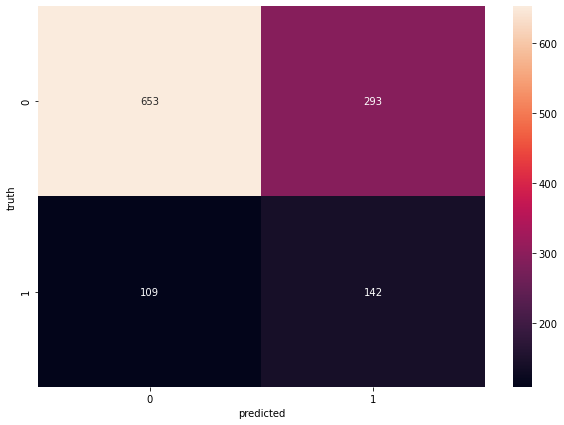

In [20]:
predictions = model.predict_classes(test_images)

import seaborn as sn
import matplotlib.pyplot as plt
cm = tf.math.confusion_matrix(labels=y_test, predictions=predictions)
plt.figure(figsize=(10, 7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('predicted')
plt.ylabel('truth')